# 实盘交易平台IB—免费数据版


## 1. IB API 框架结构

IB API 中最重要的两个大类：
* EClientSocket Class: 负责从客户端向服务器发送信息 
* EWrapper Class：负责接收服务器向客户端发送的信息，客户需要重写其中的部分方法以实现自定义行为

使用Python版ibapi构造的程序至少会包含两个线程，一个线程处理客户发送给服务器的请求（EClientSocket类或其子类），另一个线程处理服务器的反馈（EWapper类或其子类）

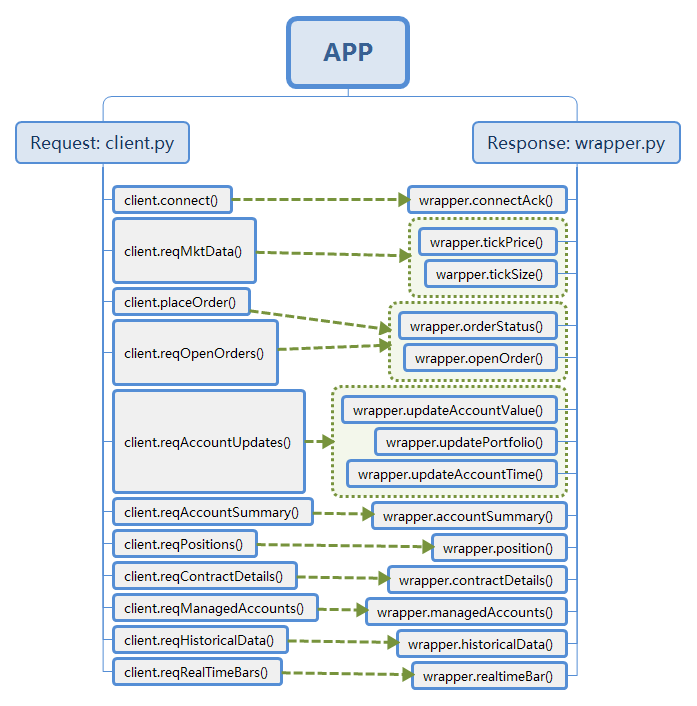

## 2. API 重要函数测试

注意事项：使用api前需要首先打开 Trader Workstation，并将语言选择为 English，选择中文api运行时会出现解码错误。

### 2.0 API 运行模式的简单说明范例

In [1]:
from datetime import datetime
import time
import threading

from ibapi import wrapper

ModuleNotFoundError: No module named 'ibapi'

In [ ]:
from datetime import datetime
import time
import threading

from ibapi import wrapper
from ibapi.client import EClient
from ibapi.order import Order
from ibapi.order_state import OrderState
from ibapi.common import *
from ibapi.contract import *
from ibapi.ticktype import *


class TestApp(wrapper.EWrapper, EClient):      # IB核心：多继承；
    def __init__(self):
        wrapper.EWrapper.__init__(self)
        EClient.__init__(self, wrapper=self)
        self.reqID = None

        # connect to the IB TWS，这个方法是在进行交易之前必须调用的；
        self.connect("127.0.0.1", 7497, clientId=123)


    # override EWrapper method
    # nextValidId() 函数是 client 模块中 reqIds() 的响应函数，client.reqIds() 会在连接服务器过程中自动被调用
    # 所以 nextValidId() 函数中定义的行为也会在连接过程中执行
    def nextValidId(self, orderId: int):
        """ Receives next valid order id. Catch valid ID after connection"""
        print("Setting nextValidOrderId: %d" % orderId)
        print("Hello Interactive Brokers")
        self.reqID = orderId
    
    # override EWrapper method
    # connectAck是和TWS平台连接成功时会自动调用的方法，可以重写这个方法；
    def connectAck(self):
        """ callback signifying completion of successful connection """
        self.logAnswer('connectAck', vars())
        print('The IB TWS is Connected.')
    
# 实例化自定义类
app = TestApp()

# app.run()             # 如果不用线程控制的话，则连接好了之后就会一直等在那，占着线程，就无法继续去做其他操作了；

# 创建新线程负责想接收用户发出的指令
client_thread = threading.Thread(target=app.run)      

# 启动线程，start()是线程对象的方法；
client_thread.start()

In [ ]:
app.reqIds(1)

In [ ]:
# 可以用来结束client_thread进程，执行后与服务器的链接会断开，存在延时问题，通信是需要时间的；
app.done = True
print(app.isConnected())

### 2.1. 定义响应函数（wrapper）行为

In [1]:
from datetime import datetime
import time, os
import threading

from ibapi import wrapper
from ibapi.client import EClient
from ibapi.order import Order
from ibapi.order_state import OrderState
from ibapi.common import *
from ibapi.contract import *
from ibapi.ticktype import *


class TestApp(wrapper.EWrapper, EClient):
    def __init__(self):
        wrapper.EWrapper.__init__(self)
        EClient.__init__(self, wrapper=self)

        self.reqID = None
        # connect to the IB TWS
        print('Connecting ...')
        self.connect("127.0.0.1", 7497, clientId=123)
        # Request frozen market data in case live is not available.
        # Different market data subscriptions give you access to different information
        # https://interactivebrokers.github.io/tws-api/market_data_type.html#gsc.tab=0
        
        # 需要请求什么样的数据，4类型是最不严格的，不开市的情况下则返回最后的交易数据；
        self.reqMarketDataType(4)

    # override EWrapper method
    # # 对应client中reqIds()方法；
    def nextValidId(self, orderId: int):
        """ Receives next valid order id. Catch valid ID after connection"""
        print("Setting nextValidOrderId: %d" % orderId)
        self.reqID = orderId
        
    # override EWrapper method
    # 服务器连接上了之后我们要做的事情；也可以自己写：在服务器连接之后看一下账户的信息；
    def connectAck(self):
        """ callback signifying completion of successful connection """
        self.logAnswer('connectAck', vars())
        print('Connected.')
        
    # override EWrapper method        
    # 对应client中reqManageAccounts()方法；在连接时候会直接调用；
    def managedAccounts(self, accountsList: str):
        """Receives a comma-separated string with the managed account ids.
            reqManagedAccts() can only be made when connected to a FA managed account"""
        self.account = accountsList.split(',')[0]  # Get the first item of the comma-delimited list
        print('\n','Account: %s' % self.account,'\n')  

    # override EWrapper method
    # 对应client中reqContractDetails()方法；
    def contractDetails(self, reqId:int, contractDetails:ContractDetails):
        """Receives the full contract's definitons. This method will return all
        contracts matching the requested via EEClientSocket::reqContractDetails.
        For example, one can obtain the whole option chain with it."""
        summary = contractDetails.summary
        print('ContractSummary: \n')
        print('Symbol: {}\nSecutiry type: {}\nExchange: {}\n'
              .format(summary.symbol, summary.secType, summary.exchange))
        print('Market: {}\nMin_tick:{}\nOrder types: {}\nValid exchanges: {}\nIndustry: {}\nCategory: {}\nTrading hours: {}'
             .format(contractDetails.marketName, contractDetails.minTick, contractDetails.orderTypes, contractDetails.validExchanges,
                     contractDetails.industry, contractDetails.category, contractDetails.tradingHours))

    # override EWrapper method
    # 因为IB的数据都是数据流，在数据流返回结束时给出提醒；
    def contractDetailsEnd(self, reqId:int):
        """This function is called once all contract details for a given
        request are received. This helps to define the end of an option
        chain."""
        print('\n', 'reqContractDetails() test complete')

    # override EWrapper method
    # 对应client中reqHistoricalData()方法；
    def historicalData(self, reqId: int, bar):
        """ returns the requested historical data bars

        reqId - the request's identifier
        date  - the bar's date and time (either as a yyyymmss hh:mm:ssformatted
             string or as system time according to the request)
        open  - the bar's open point
        high  - the bar's high point
        low   - the bar's low point
        close - the bar's closing point
        volume - the bar's traded volume if available
        count - the number of trades during the bar's timespan (only available
            for TRADES).
        WAP -   the bar's Weighted Average Price
        hasGaps  -indicates if the data has gaps or not. """
        print('{} {} {} {} {}'.format(bar.date, bar.open, bar.high, bar.low, bar.close))
        print('hello')            # 从这个例子中可以更好体现出响应函数的特征；

    # override EWrapper method
    # 因为IB的数据都是数据流，在数据流返回结束时给出提醒；
    def historicalDataEnd(self, reqId:int, start:str, end:str):
        """ Marks the ending of the historical bars reception. """
        print('\n','reqHistoricalData() test complete')
        
    # override EWrapper method
    # 对应client中reqMktData()方法，从IB获得实时数据；
    def tickPrice(self, reqId: TickerId , tickType: TickType, price: float,
                  attrib:TickAttrib):
        """Market data tick price callback. Handles all price related ticks."""
        if tickType == 2:  # only print ask price
            print("Time: ", str(datetime.now()), " Ticker Id:", reqId, " tickType:", tickType, "Price:", price)

    # override EWrapper method
    # 对应client中reqRealTimeBars()方法；
    def realtimeBar(self, reqId: TickerId, time:int, open: float, high: float, low: float, close: float,
                        volume: int, wap: float, count: int):
        """ Updates the real time 5 seconds bars

        reqId - the request's identifier
        bar.time  - start of bar in unix (or 'epoch') time
        bar.endTime - for synthetic bars, the end time (requires TWS v964). Otherwise -1.
        bar.open  - the bar's open value
        bar.high  - the bar's high value
        bar.low   - the bar's low value
        bar.close - the bar's closing value
        bar.volume - the bar's traded volume if available
        bar.WAP   - the bar's Weighted Average Price
        bar.count - the number of trades during the bar's timespan (only available
            for TRADES)."""
        print('ReqID: %d'% reqId, ' Time: ', str(datetime.fromtimestamp(time)), '\t', open, '\t', high, '\t', low, '\t', close)
        
    # override EWrapper method
    # 对应client中placeOrder方法和reqOpenOrders()方法；
    # 注意该方法是只要订单状态发生改变就会触发该方法；
    def orderStatus(self, orderId: OrderId, status: str, filled: float,
                remaining: float, avgFillPrice: float, permId: int,
                parentId: int, lastFillPrice: float, clientId: int,
                whyHeld: str):
        """This event is called whenever the status of an order changes. It is
        also fired after reconnecting to TWS if the client has any open orders.

        orderId: OrderId - The order ID that was specified previously in the
            call to placeOrder()
        status:str - The order status. Possible values include:
            PendingSubmit - indicates that you have transmitted the order, but have not  yet received confirmation that it has been accepted by the order destination. NOTE: This order status is not sent by TWS and should be explicitly set by the API developer when an order is submitted.
            PendingCancel - indicates that you have sent a request to cancel the order but have not yet received cancel confirmation from the order destination. At this point, your order is not confirmed canceled. You may still receive an execution while your cancellation request is pending. NOTE: This order status is not sent by TWS and should be explicitly set by the API developer when an order is canceled.
            PreSubmitted - indicates that a simulated order type has been accepted by the IB system and that this order has yet to be elected. The order is held in the IB system until the election criteria are met. At that time the order is transmitted to the order destination as specified.
            Submitted - indicates that your order has been accepted at the order destination and is working.
            Cancelled - indicates that the balance of your order has been confirmed canceled by the IB system. This could occur unexpectedly when IB or the destination has rejected your order.
            Filled - indicates that the order has been completely filled.
            Inactive - indicates that the order has been accepted by the system (simulated orders) or an exchange (native orders) but that currently the order is inactive due to system, exchange or other issues.
        filled:int - Specifies the number of shares that have been executed.
            For more information about partial fills, see Order Status for Partial Fills.
        remaining:int -   Specifies the number of shares still outstanding.
        avgFillPrice:float - The average price of the shares that have been executed. This parameter is valid only if the filled parameter value is greater than zero. Otherwise, the price parameter will be zero.
        permId:int -  The TWS id used to identify orders. Remains the same over TWS sessions.
        parentId:int - The order ID of the parent order, used for bracket and auto trailing stop orders.
        lastFilledPrice:float - The last price of the shares that have been executed. This parameter is valid only if the filled parameter value is greater than zero. Otherwise, the price parameter will be zero.
        clientId:int - The ID of the client (or TWS) that placed the order. Note that TWS orders have a fixed clientId and orderId of 0 that distinguishes them from API orders.
        whyHeld:str - This field is used to identify an order held when TWS is trying to locate shares for a short sell. The value used to indicate this is 'locate'.

        """
        print('OrderId: {}, Status:{}  Filled: {}  AverageFillPrice: {} Remaining: {} permid: {} parentid: {} lastFillPrice: {} clientId: {} whyHeld:{}'
              .format(orderId, status, filled, avgFillPrice, remaining, permId, parentId, lastFillPrice, clientId, whyHeld))
        print('\n')
     
    # override EWrapper method
    # 对应client中placeOrder方法和reqOpenOrders()方法；
    def openOrder(self, orderId:OrderId, contract:Contract, order:Order,
                  orderState:OrderState):
        print('OrderId: {},\ncontract: {},\norder_direction: {},\norder_type: {},\nlmt_price/stp_price: {}/{},\norder_state:{} '
              .format(orderId, contract.symbol, order.action, order.orderType, order.lmtPrice, order.auxPrice, orderState.status))
     
    # override EWrapper method
    # 对应client中reqPositions()方法；
    def position(self, account:str, contract:Contract, position:float,
                 avgCost:float):
        print('Account: {}'.format(account))
        print('Contract: {}, \nPosition: {}，\navgCost: {}'.format(contract.symbol, position, avgCost))
    
    # override EWrapper method
    # 调用position结束的通知；
    def positionEnd(self):
        """This function is called to feed in open orders.

        orderID: OrderId - The order ID assigned by TWS. Use to cancel or
            update TWS order.
        contract: Contract - The Contract class attributes describe the contract.
        order: Order - The Order class gives the details of the open order.
        orderState: OrderState - The orderState class includes attributes Used
            for both pre and post trade margin and commission data."""
        print('reqPosition() test complete.')
        print('\n')
    
    # override EWrapper method
    # 对应client中reqAccountsSummary()方法；
    def accountSummary(self, reqId: int, account: str, tag: str, value: str,
                       currency: str):
        """Returns the data from the TWS Account Window Summary tab in
        response to reqAccountSummary()."""
        print('Account: {}'.format(account))
        print('{}: {}'.format(tag, value))
        print('ReqId: {}'.format(reqId))
        print('\n')
        
    # override EWrapper method
    def accountSummaryEnd(self, reqId:int):
        """This method is called once all account summary data for a
        given request are received."""
        print('reqAccountSummary() test complete')
        print('\n')
        
    # override EWrapper method
    # 对应client中reqAccountUpdates()方法；
    def updateAccountTime(self, timeStamp:str):
        """callback function of client.reqAccountUpdates"""
        print('Last update time: %s' % timeStamp)
   
    # override EWrapper method
    # 对应client中reqAccountUpdates()方法；
    def updatePortfolio(self, contract:Contract, position:float,
                        marketPrice:float, marketValue:float,
                        averageCost:float, unrealizedPNL:float,
                        realizedPNL:float, accountName:str):
        """This function is called only when reqAccountUpdates on
        EEClientSocket object has been called."""
        
        print('Account: {}'.format(accountName))
        print('Symbol: {} \nPosition: {} \nMarketValue: {}\nAverageCost: {}'
              .format(contract.symbol, position, marketValue, averageCost))


app = TestApp()

# run()是client的方法；
client_thread = threading.Thread(target=app.run)  # Initialize a thread which will run the run() method of the EClient class 

# start是Thread的方法，用于启动线程；
client_thread.start()

Connecting ...
Connected.

 Account: DU229334

ERROR:root:ERROR -1 2104 Market data farm connection is OK:hfarm


 

Setting nextValidOrderId: 48


ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:ushmds


In [ ]:
# 可以用来结束client_thread进程，执行后与服务器的链接会断开
app.done = True
print(app.isConnected())

In [18]:
app.reqIds(1)

Setting nextValidOrderId: 50


In [20]:
app.reqID

50

### 2.2. 测试请求函数

#### 2.2.1. 定义合约属性

In [10]:
# 定义外汇合约
def fx_contract(symbol: str):
    """
    定义查询合约属性，服务器根据属性匹配合约返回数据，如果对应到一个以上的合约会报错
    :param symbol: 比如 ’EUR', 'APPL'
    :param secType: 证券类型，股票：‘STK', 外汇：’CASH', 商品：‘CMDTY', 指数：’IND'...
    :return: 返回定义好的合约
    """
    contract = Contract()
    contract.symbol = symbol
    contract.secType =  'CASH'
    contract.currency = "USD"
    contract.exchange = 'IDEALPRO'
    return contract

# 定义股票合约
def stock_contract(symbol: str):
    """
    定义查询合约属性，服务器根据属性匹配合约返回数据，如果对应到一个以上的合约会报错
    :param symbol: 比如 ’EUR', 'APPL'
    :param secType: 证券类型，股票：‘STK', 外汇：’CASH', 商品：‘CMDTY', 指数：’IND'...
    :return: 返回定义好的合约
    """
    contract = Contract()
    contract.symbol = symbol
    contract.secType = 'STK'
    contract.currency = "USD"
    contract.exchange = 'ISLAND'
    return contract    

# 更多合约类型可以参考api安装路径下 ...IB_API\samples\Python\Testbed\ContractSamples.py

#### 2.2.2. 获取合约信息

In [21]:
# def reqContractDetails(self, reqId:int , contract:Contract):
# """Call this function to download all details for a particular
# underlying. The contract details will be received via the contractDetails()
# function on the EWrapper.

# reqId:int - The ID of the data request. Ensures that responses are
#     make_fieldatched to requests if several requests are in process.
# contract:Contract - The summary description of the contract being looked
#     up."""

# 定义合约属性
contract = fx_contract('EUR')
# 请求匹配合约信息
app.reqContractDetails(app.reqID, contract)
app.reqID += 1

ContractSummary: 

Symbol: EUR
Secutiry type: CASH
Exchange: IDEALPRO

Market: EUR.USD
Min_tick:5e-05
Order types: ACTIVETIM,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,BASKET,CASHQTY,COND,CONDORDER,DAY,DEACT,DEACTDIS,DEACTEOD,GAT,GTC,GTD,GTT,HID,IOC,LIT,LMT,MIT,MKT,NONALGO,OCA,REL,SCALE,SCALERST,STP,STPLMT,TRAIL,TRAILLIT,TRAILLMT,TRAILMIT,WHATIF
Valid exchanges: IDEALPRO
Industry: 
Category: 
Trading hours: 20170926:1715-1700;20170927:1715-1700;20170928:1715-1700;20170929:1715-1700;20170930:1715-1700;20171001:CLOSED;20171002:CLOSED;20171003:1715-1700;20171004:1715-1700;20171005:1715-1700;20171006:1715-1700;20171007:1715-1700;20171008:CLOSED;20171009:CLOSED;20171010:1715-1700;20171011:1715-1700;20171012:1715-1700;20171013:1715-1700;20171014:1715-1700;20171015:CLOSED;20171016:CLOSED;20171017:1715-1700;20171018:1715-1700;20171019:1715-1700;20171020:1715-1700;20171021:1715-1700;20171022:CLOSED;20171023:CLOSED;20171024:1715-1700;20171025:1715-1700;20171026:1715-1700;20171027:1715-1700;20171028:1715-17

In [23]:
contract2 = stock_contract('AAPL')
# 请求匹配合约信息
app.reqContractDetails(app.reqID, contract2)
app.reqID += 1

ContractSummary: 

Symbol: AAPL
Secutiry type: STK
Exchange: ISLAND

Market: NMS
Min_tick:0.01
Order types: ACTIVETIM,ADJUST,ALERT,ALLOC,AVGCOST,BASKET,COND,CONDORDER,DAY,DEACT,DEACTDIS,DEACTEOD,DIS,GAT,GTC,GTD,GTT,HID,IOC,LIT,LMT,LOC,MIT,MKT,MOC,MTL,NGCOMB,NONALGO,OCA,OPG,PEGBENCH,RTH,SCALE,SCALERST,SNAPMID,SNAPMKT,SNAPREL,STP,STPLMT,TRAIL,TRAILLIT,TRAILLMT,TRAILMIT,WHATIF
Valid exchanges: SMART,AMEX,CBOE,ISE,CHX,ARCA,ISLAND,VWAP,DRCTEDGE,NSX,BEX,BATS,EDGEA,CSFBALGO,JEFFALGO,BYX,IEX,PSX
Industry: Technology
Category: Computers
Trading hours: 20170926:0400-2000;20170927:0400-2000;20170928:0400-2000;20170929:0400-2000;20170930:CLOSED;20171001:CLOSED;20171002:0400-2000;20171003:0400-2000;20171004:0400-2000;20171005:0400-2000;20171006:0400-2000;20171007:CLOSED;20171008:CLOSED;20171009:0400-2000;20171010:0400-2000;20171011:0400-2000;20171012:0400-2000;20171013:0400-2000;20171014:CLOSED;20171015:CLOSED;20171016:0400-2000;20171017:0400-2000;20171018:0400-2000;20171019:0400-2000;20171020:0400

#### 2.2.2. 获取历史数据

In [24]:
# 获取历史数据，免费账户最多可以获取一周历史数据
# def reqHistoricalData(self, reqId:TickerId , contract:Contract, endDateTime:str,
#                       durationStr:str, barSizeSetting:str, whatToShow:str,
#                       useRTH:int, formatDate:int, keepUpToDate:bool, chartOptions:TagValueList):
# """Requests contracts' historical data. When requesting historical data, a
# finishing time and date is required along with a duration string. The
# resulting bars will be returned in EWrapper.historicalData()

# reqId:TickerId - The id of the request. Must be a unique value. When the
#     market data returns, it whatToShowill be identified by this tag. This is also
#     used when canceling the market data.
# contract:Contract - This object contains a description of the contract for which
#     market data is being requested.
# endDateTime:str - Defines a query end date and time at any point during the past 6 mos.
#     Valid values include any date/time within the past six months in the format:
#     yyyymmdd HH:mm:ss ttt

#     where "ttt" is the optional time zone.
# durationStr:str - Set the query duration up to one week, using a time unit
#     of seconds, days or weeks. Valid values include any integer followed by a space
#     and then S (seconds), D (days) or W (week). If no unit is specified, seconds is used.
# barSizeSetting:str - Specifies the size of the bars that will be returned (within IB/TWS listimits).
#     Valid values include:
#     1 sec
#     5 secs
#     15 secs
#     30 secs
#     1 min
#     2 mins
#     3 mins
#     5 mins
#     15 mins
#     30 mins
#     1 hour
#     1 day
# whatToShow:str - Determines the nature of data beinging extracted. Valid values include:

#     TRADES
#     MIDPOINT
#     BID
#     ASK
#     BID_ASK
#     HISTORICAL_VOLATILITY
#     OPTION_IMPLIED_VOLATILITY
# useRTH:int - Determines whether to return all data available during the requested time span,
#     or only data that falls within regular trading hours. Valid values include:

#     0 - all data is returned even where the market in question was outside of its
#     regular trading hours.
#     1 - only data within the regular trading hours is returned, even if the
#     requested time span falls partially or completely outside of the RTH.
# formatDate: int - Determines the date format applied to returned bars. validd values include:

#     1 - dates applying to bars returned in the format: yyyymmdd{space}{space}hh:mm:dd
#     2 - dates are returned as a long integer specifying the number of seconds since
#         1/1/1970 GMT.
# keepUpToDate: Bool value
# chartOptions:TagValueList - For internal use only. Use default value XYZ. 

# 关于订阅历史数据的官方文档说明：http://interactivebrokers.github.io/tws-api/historical_data.html
# 不能读取实时数据的时间段里，同样也不能读取历史数据"""

# 定义合约属性
contract = fx_contract('EUR')

# 请求历史数据
app.reqHistoricalData(app.reqID, contract,
     '20170907 00:00:00', '1260 S', '1 min', 'BID_ASK', 1, 1, False, [])
app.reqID += 1

20170906  23:39:00 1.19453 1.19464 1.19444 1.19454
hello
20170906  23:40:00 1.19444 1.19463 1.19424 1.19446
hello
20170906  23:41:00 1.19424 1.19444 1.19409 1.19426
hello
20170906  23:42:00 1.19426 1.19438 1.1942 1.19428
hello
20170906  23:43:00 1.19431 1.19442 1.19421 1.19432
hello
20170906  23:44:00 1.19421 1.19433 1.19412 1.19423
hello
20170906  23:45:00 1.19432 1.19441 1.19426 1.19434
hello
20170906  23:46:00 1.19437 1.19445 1.1943 1.19439
hello
20170906  23:47:00 1.19439 1.19448 1.19434 1.19441
hello
20170906  23:48:00 1.19445 1.19455 1.1944 1.19446
hello
20170906  23:49:00 1.19455 1.19464 1.19447 1.19457
hello
20170906  23:50:00 1.19446 1.19459 1.19436 1.19448
hello
20170906  23:51:00 1.19456 1.19466 1.19447 1.19458
hello
20170906  23:52:00 1.19463 1.19475 1.19455 1.19465
hello
20170906  23:53:00 1.19458 1.19467 1.19452 1.1946
hello
20170906  23:54:00 1.19456 1.19463 1.19452 1.19458
hello
20170906  23:55:00 1.19462 1.19469 1.19459 1.19464
hello
20170906  23:56:00 1.19464 1.19469 

In [27]:
contract2 = stock_contract('AAPL')

# 请求历史数据
app.reqHistoricalData(app.reqID, contract2,
     '20170907 00:00:00', '1260 S', '1 min', 'BID_ASK', 1, 1, False, [])
app.reqID += 1

ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:ushmds.us
ERROR:root:ERROR 54 162 Historical Market Data Service error message:No market data permissions for ISLAND STK
ERROR:root:ERROR 54 162 Historical Market Data Service error message:No market data permissions for ISLAND STK


#### 2.2.3. 获取实时市场tick数据

In [28]:
# def reqMktData(self, reqId:TickerId, contract:Contract,
#                 genericTickList:str, snapshot:bool, regulatorySnapshot: bool,
#                 mktDataOptions:TagValueList):
#     """Call this function to request market data. The market data
#     will be returned by the tickPrice and tickSize events.

#     reqId: TickerId - The ticker id. Must be a unique value. When the
#         market data returns, it will be identified by this tag. This is
#         also used when canceling the market data.
#     contract:Contract - This structure contains a description of the
#         Contractt for which market data is being requested.
#     genericTickList:str - A commma delimited list of generic tick types.
#         Tick types can be found in the Generic Tick Types page.
#         Prefixing w/ 'mdoff' indicates that top mkt data shouldn't tick.
#         You can specify the news source by postfixing w/ ':<source>.
#         Example: "mdoff,292:FLY+BRF"
#     snapshot:bool - Check to return a single snapshot of Market data and
#         have the market data subscription cancel. Do not enter any
#         genericTicklist values if you use snapshots.
#     regulatorySnapshot: bool - With the US Value Snapshot Bundle for stocks,
#         regulatory snapshots are available for 0.01 USD each.
#     mktDataOptions:TagValueList - For internal use only.
#         Use default value XYZ. """

# 定义合约属性
contract = fx_contract('EUR')

# 请求实时数据
for i in range(30):
    app.reqMktData(app.reqID, contract, '', True, False, [])
    app.reqID += 1
    

Time:  2017-09-26 16:16:17.380563  Ticker Id: 55  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.430695  Ticker Id: 56  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.472808  Ticker Id: 57  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.819526  Ticker Id: 58  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.866652  Ticker Id: 59  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.913276  Ticker Id: 60  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.957393  Ticker Id: 61  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:17.958897  Ticker Id: 62  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:18.302923  Ticker Id: 63  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:18.304929  Ticker Id: 64  tickType: 2 Price: 1.1814
Time:  2017-09-26 16:16:18.348545  Ticker Id: 65  tickType: 2 Price: 1.18141
Time:  2017-09-26 16:16:18.350550  Ticker Id: 66  tickType: 2 Price: 1.18141
Time:  2017-09-26 16:16:18.395670  Ticker Id: 67  tickType: 2 Price: 1.18141
Time:  20

#### 2.2.4. 获取实时Bar数据

In [31]:
# 获取bar数据，当前仅支持5秒周期的bar数据
# def reqRealTimeBars(self, reqId:TickerId, contract:Contract, barSize:int,
#                     whatToShow:str, useRTH:bool,
#                     realTimeBarsOptions:TagValueList):
#     """Call the reqRealTimeBars() function to start receiving real time bar
#     results through the realtimeBar() EWrapper function.

#     reqId:TickerId - The Id for the request. Must be a unique value. When the
#         data is received, it will be identified by this Id. This is also
#         used when canceling the request.
#     contract:Contract - This object contains a description of the contract
#         for which real time bars are being requested
#     barSize:int - Currently only 5 second bars are supported, if any other
#         value is used, an exception will be thrown.
#     whatToShow:str - Determines the nature of the data extracted. Valid
#         values include:
#         TRADES
#         BID
#         ASK
#         MIDPOINT
#     useRTH:bool - Regular Trading Hours only. Valid values include:
#         0 = all data available during the time span requested is returned,
#             including time intervals when the market in question was
#             outside of regular trading hours.
#         1 = only data within the regular trading hours for the product
#             requested is returned, even if the time time span falls
#             partially or completely outside.
#     realTimeBarOptions:TagValueList - For internal use only. Use default value XYZ."""

# 定义合约属性
contract = fx_contract('EUR')
app.reqRealTimeBars(app.reqID, contract, 5, 'MIDPOINT', 1, [])
app.reqID += 1

ReqID: 115  Time:  2017-09-26 16:18:30 	 1.18105 	 1.181055 	 1.181005 	 1.181025
ReqID: 115  Time:  2017-09-26 16:18:35 	 1.181025 	 1.18103 	 1.181 	 1.181015
ReqID: 115  Time:  2017-09-26 16:18:40 	 1.181015 	 1.181025 	 1.181005 	 1.181015
ReqID: 115  Time:  2017-09-26 16:18:45 	 1.181015 	 1.181025 	 1.180995 	 1.181005
ReqID: 115  Time:  2017-09-26 16:18:50 	 1.181005 	 1.18104 	 1.180995 	 1.181025


In [32]:
# 取消实时 bar 数据订阅
app.cancelRealTimeBars(115)                #这个ReqID还是有意义的；控制请求编号，每个不一样；

### 2.3 IB交易操作

#### 2.3.1 定义订单属性

In [11]:
# 定义市价单
def create_mkt_order(action: str, quantity: int):
    """ Creates a market order."""
    order = Order()
    order.action = action
    order.totalQuantity = quantity
    order.account = app.account
    order.orderType = 'MKT'
    order.orderId = app.reqID
    app.reqID += 1
    return order

# 定义限价单
def create_lmt_order(action: str, quantity: int, lmtPrice):
    """ Creates a limit order."""
    order = Order()
    order.action = action
    order.totalQuantity = quantity
    order.account = app.account
    order.orderType = 'LMT'
    order.orderId = app.reqID
    order.lmtPrice = lmtPrice 
    app.reqID += 1
    return order

# 定义止价单
def create_stp_order(action: str, quantity: int, stpPrice):
    """ Creates a stop order."""
    order = Order()
    order.action = action
    order.totalQuantity = quantity
    order.account = app.account
    order.orderType = 'STP'
    order.orderId = app.reqID
    order.auxPrice = stpPrice 
    app.reqID += 1
    return order

#### 2.3.2 下单

In [34]:
# 市价下单
# def placeOrder(self, orderId:OrderId , contract:Contract, order:Order):
#     """“Call this function to place an order. The order status will
#     be returned by the orderStatus and openOrders event.

#     orderId:OrderId - The order id. You must specify a unique value. When the
#         order START_APItus returns, it will be identified by this tag.
#         This tag is also used when canceling the order.
#     contract:Contract - This structure contains a description of the
#         contract which is being traded.
#     order:Order - This structure contains the details of tradedhe order.
#         Note: Each client MUST connect with a unique clientId.""""

# 定义订单属性
mkt_order = create_mkt_order('SELL', 20000)
# mkt_order = create_mkt_order('BUY', 200)

# 定义合约属性
contract = fx_contract('EUR')
# contract = stock_contract('AAPL')

# 发送下单请求
# placeOrder方法会同时触发Wrapper中的openOrder()方法和orderStatus()方法；
app.placeOrder(app.reqID, contract, mkt_order)
app.reqID += 1

Account: DU229334
Contract: EUR, 
Position: -40000.0，
avgCost: 1.183495
OrderId: 51,
contract: EUR,
order_direction: SELL,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 51, Status:Filled  Filled: 20000.0  AverageFillPrice: 1.18131 Remaining: 0.0 permid: 1539721486 parentid: 0 lastFillPrice: 1.18131 clientId: 123 whyHeld:


OrderId: 51,
contract: EUR,
order_direction: SELL,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 51, Status:Filled  Filled: 20000.0  AverageFillPrice: 1.18131 Remaining: 0.0 permid: 1539721486 parentid: 0 lastFillPrice: 1.18131 clientId: 123 whyHeld:


OrderId: 51,
contract: EUR,
order_direction: SELL,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 51, Status:Filled  Filled: 20000.0  AverageFillPrice: 1.18131 Remaining: 0.0 permid: 1539721486 parentid: 0 lastFillPrice: 1.18131 clientId: 123 whyHeld:




ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm


In [37]:
# 如果尝试美股的下单的话，必须是在北京时间晚上；
mkt_order = create_mkt_order('BUY', 200)

contract = stock_contract('AAPL')

app.placeOrder(app.reqID, contract, mkt_order)
app.reqID += 1

Account: DU229334
Contract: AAPL, 
Position: 0.0，
avgCost: 0.0
Account: DU229334
Contract: AAPL, 
Position: 200.0，
avgCost: 151.17
OrderId: 55,
contract: AAPL,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 55, Status:Filled  Filled: 200.0  AverageFillPrice: 151.17 Remaining: 0.0 permid: 1539721488 parentid: 0 lastFillPrice: 151.17 clientId: 123 whyHeld:


OrderId: 55,
contract: AAPL,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 55, Status:Filled  Filled: 200.0  AverageFillPrice: 151.17 Remaining: 0.0 permid: 1539721488 parentid: 0 lastFillPrice: 151.17 clientId: 123 whyHeld:


Account: DU229334
Contract: EUR, 
Position: -40000.0，
avgCost: 1.183445
Account: DU229334
Contract: AAPL, 
Position: 200.0，
avgCost: 151.1775
OrderId: 55,
contract: AAPL,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 55, Status:Filled  Filled: 200.0  AverageF

ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm


In [41]:
# 限价下单
# 定义订单属性
lmt_order = create_lmt_order('BUY', 20000, 1.17)
# 定义合约属性
contract = fx_contract('EUR')

# placeOrder方法会同时触发Wrapper中的openOrder()方法和orderStatus()方法；
app.placeOrder(app.reqID, contract, lmt_order)
app.reqID += 1

OrderId: 57,
contract: EUR,
order_direction: BUY,
order_type: LMT,
lmt_price/stp_price: 1.17/0.0,
order_state:Submitted 
OrderId: 57, Status:Submitted  Filled: 0.0  AverageFillPrice: 0.0 Remaining: 20000.0 permid: 1539721493 parentid: 0 lastFillPrice: 0.0 clientId: 123 whyHeld:




In [ ]:
# 止价下单
# 定义订单属性
stp_order = create_stp_order('BUY', 20000, 1.22)
# 定义合约属性
contract = fx_contract('EUR')
app.placeOrder(app.reqID, contract, stp_order)
app.reqID += 1

#### 2.3.3 订单管理

In [42]:
# 查询开放订单
# def reqOpenOrders(self):
#     """Call this function to request the open orders that were
#     placed from this client. Each open order will be fed back through the
#     openOrder() and orderStatus() functions on the EWrapper."""


# repOpenOrders方法会同时也会同时触发Wrapper中的openOrder()方法和orderStatus()方法； 
# OpenOrders是已挂单尚未成交的单子，注意和Oanda的区别；

app.reqOpenOrders()

OrderId: 57,
contract: EUR,
order_direction: BUY,
order_type: LMT,
lmt_price/stp_price: 1.17/0.0,
order_state:Submitted 
OrderId: 57, Status:Submitted  Filled: 0.0  AverageFillPrice: 0.0 Remaining: 20000.0 permid: 1539721493 parentid: 0 lastFillPrice: 0.0 clientId: 123 whyHeld:




In [39]:
# 指定单号撤单
# def cancelOrder(self, orderId:OrderId):
#     """Call this function to cancel an order.

#     orderId:OrderId - The order ID that was specified previously in the call
#         to placeOrder()"""

app.cancelOrder(53)

ERROR:root:ERROR 53 202 Order Canceled - reason:


OrderId: 53, Status:Cancelled  Filled: 0.0  AverageFillPrice: 0.0 Remaining: 20000.0 permid: 1539721487 parentid: 0 lastFillPrice: 0.0 clientId: 123 whyHeld:




In [43]:
# 取消全部未成交订单,一键撤单
# def reqGlobalCancel(self):
#     """Use this function to cancel all open orders globally. It
#     cancels both API and TWS open orders."""
app.reqGlobalCancel()

ERROR:root:ERROR 57 202 Order Canceled - reason:


OrderId: 57, Status:Cancelled  Filled: 0.0  AverageFillPrice: 0.0 Remaining: 20000.0 permid: 1539721493 parentid: 0 lastFillPrice: 0.0 clientId: 123 whyHeld:




ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm


### 2.4 仓位管理

In [46]:
# 查询持仓
# def reqPositions(self):
#     """Requests real-time position data for all accounts."""
app.reqPositions()

Account: DU229334
Contract: EUR, 
Position: -20000.0，
avgCost: 1.183445
Account: DU229334
Contract: AAPL, 
Position: 200.0，
avgCost: 151.1775
reqPosition() test complete.




In [45]:
# 定义订单属性
mkt_order = create_mkt_order('BUY', 20000)

# 定义合约属性
contract = fx_contract('EUR')

# 发送下单请求
# placeOrder方法会同时触发Wrapper中的openOrder()方法和orderStatus()方法；
app.placeOrder(app.reqID, contract, mkt_order)
app.reqID += 1

Account: DU229334
Contract: EUR, 
Position: -20000.0，
avgCost: 1.183445
OrderId: 59,
contract: EUR,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 59, Status:Filled  Filled: 20000.0  AverageFillPrice: 1.18168 Remaining: 0.0 permid: 1539721494 parentid: 0 lastFillPrice: 1.18168 clientId: 123 whyHeld:


OrderId: 59,
contract: EUR,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 59, Status:Filled  Filled: 20000.0  AverageFillPrice: 1.18168 Remaining: 0.0 permid: 1539721494 parentid: 0 lastFillPrice: 1.18168 clientId: 123 whyHeld:


OrderId: 59,
contract: EUR,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 0.0/0.0,
order_state:Filled 
OrderId: 59, Status:Filled  Filled: 20000.0  AverageFillPrice: 1.18168 Remaining: 0.0 permid: 1539721494 parentid: 0 lastFillPrice: 1.18168 clientId: 123 whyHeld:




ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm


In [47]:
# 取消账户信息订阅
app.cancelPositions()

### 2.5 账户管理

In [48]:
# 账户概况
# def reqAccountSummary(self, reqId:int, groupName:str, tags:str):
#     """Call this method to request and keep up to date the data that appears
#     on the TWS Account Window Summary tab. The data is returned by
#     accountSummary().

#     reqId:int - The ID of the data request. Ensures that responses are matched
#         to requests If several requests are in process.
#     groupName:str - Set to All to returnrn account summary data for all
#         accounts, or set to a specific Advisor Account Group name that has
#         already been created in TWS Global Configuration.
#     tags:str - A comma-separated list of account tags.  Available tags are:
#         accountountType
#         NetLiquidation,
#         TotalCashValue - Total cash including futures pnl
#         SettledCash - For cash accounts, this is the same as
#         TotalCashValue
#         AccruedCash - Net accrued interest
#         BuyingPower - The maximum amount of marginable US stocks the
#             account can buy
#         EquityWithLoanValue - Cash + stocks + bonds + mutual funds
#         PreviousDayEquityWithLoanValue,
#         GrossPositionValue - The sum of the absolute value of all stock
#             and equity option positions
#         RegTEquity,
#         RegTMargin,
#         SMA - Special Memorandum Account
#         InitMarginReq,
#         MaintMarginReq,
#         AvailableFunds,
#         ExcessLiquidity,
#         Cushion - Excess liquidity as a percentage of net liquidation value
#         FullInitMarginReq,
#         FullMaintMarginReq,
#         FullAvailableFunds,
#         FullExcessLiquidity,
#         LookAheadNextChange - Time when look-ahead values take effect
#         LookAheadInitMarginReq,
#         LookAheadMaintMarginReq,
#         LookAheadAvailableFunds,
#         LookAheadExcessLiquidity,
#         HighestSeverity - A measure of how close the account is to liquidation
#         DayTradesRemaining - The Number of Open/Close trades a user
#             could put on before Pattern Day Trading is detected. A value of "-1"
#             means that the user can put on unlimited day trades.
#         Leverage - GrossPositionValue / NetLiquidation
#         $LEDGER - Single flag to relay all cash balance tags*, only in base
#             currency.
#         $LEDGER:CURRENCY - Single flag to relay all cash balance tags*, only in
#             the specified currency.
#         $LEDGER:ALL - Single flag to relay all cash balance tags* in all
#         currencies."""
app.reqAccountSummary(app.reqID, 'All', 'NetLiquidation, TotalCashValue, AvailableFunds')
app.reqID += 1

Account: DU229334
AvailableFunds: 995034.85
ReqId: 60


Account: DU229334
NetLiquidation: 1003302.35
ReqId: 60


Account: DU229334
TotalCashValue: 972631.60
ReqId: 60


reqAccountSummary() test complete




In [51]:
app.cancelAccountSummary(60)

ERROR:root:ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:hfarm
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:ushmds
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:cashhmds
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:hkhmds
ERROR:root:ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfarm.us
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm.us
ERROR:root:ERROR -1 2103 Market data farm connection is broken:secdefhk
ERROR:root:ERROR -1 2104 Market data farm connection is OK:secdefhk
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfarm
ERROR:root:ERROR -1 2103 Market data far

In [50]:
# 账户实时更新
# def reqAccountUpdates(self, subscribe:bool, acctCode:str):
#     """Call this function to start getting account values, portfolio,
#     and last update time information via EWrapper.updateAccountValue(),
#     EWrapperi.updatePortfolio() and Wrapper.updateAccountTime().

#     subscribe:bool - If set to TRUE, the client will start receiving account
#         and Portfoliolio updates. If set to FALSE, the client will stop
#         receiving this information.
#     acctCode:str -The account code for which to receive account and
#         portfolio updates."""


# 通过参数True和False来控制是否持续接受更新；
app.reqAccountUpdates(False, app.account)             

ERROR:root:ERROR -1 2100 API client has been unsubscribed from account data.


声明：本资料仅限内部研究使用，切勿外传。